# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда.



In [2]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3,
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader


In [3]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64,
                                                         transform_train=transform)

100%|██████████| 170498071/170498071 [00:02<00:00, 81733848.11it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Посмотрим на изображения:

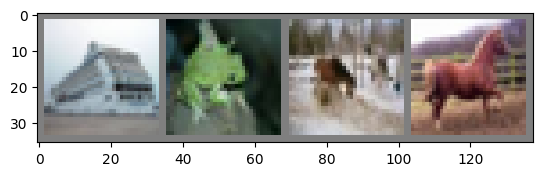

ship frog horse horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [5]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.first_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding='same'),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same'),
        nn.BatchNorm2d(32)
        )
        self.second_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1)
        )
        self.third_model = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 8),
            nn.Flatten(1),
            nn.Linear(in_features=512, out_features = 10)
        )

    def forward(self, x):
        out = self.third_model(self.first_model(x) + self.second_model(x))

        return out

In [6]:
net = BasicBlockNet()
net

BasicBlockNet(
  (first_model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (second_model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (third_model): Sequential(
    (0): ReLU()
    (1): AvgPool2d(kernel_size=8, stride=8, padding=0)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)

Проверим, что выход сети имеет корректную размерность:

In [7]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [9]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [10]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)

        output = model(data)

        loss = loss_fn(output, target)
        loss_log.append(loss.item())
        acc = (output.argmax(dim=1) == target).sum() / data.shape[0]
        acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(data)

        loss = loss_fn(output, target)
        loss.backward()
        loss_log.append(loss.item())
        acc = (output.argmax(dim=1) == target).sum() / data.shape[0]
        acc_log.append(acc.item())
        optimizer.step()

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [11]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.4585839658158353, train acc: 0.4809920998116516
 val loss: 1.1940569801533476, val acc: 0.5740913122258288

Epoch 1
 train loss: 1.1433228667301059, train acc: 0.6006871898823726
 val loss: 1.1415387858735755, val acc: 0.6050088652904998

Epoch 2
 train loss: 1.036458638947886, train acc: 0.639841505661743
 val loss: 1.094320327931262, val acc: 0.6289671986661058

Epoch 3
 train loss: 0.9844494389005727, train acc: 0.6575639853747715
 val loss: 1.069851510829114, val acc: 0.6330230497299356

Epoch 4
 train loss: 0.9493335418988843, train acc: 0.6698305694015196
 val loss: 1.0065980619572579, val acc: 0.6548093973322118

Epoch 5
 train loss: 0.9276158970932202, train acc: 0.6783837163905992
 val loss: 0.9566395353763661, val acc: 0.6708111702127659

Epoch 6
 train loss: 0.9014830935807725, train acc: 0.686447179513614
 val loss: 1.0599963807045145, val acc: 0.6477615249917862

Epoch 7
 train loss: 0.8815304773708148, train acc: 0.6926131170018281
 val loss: 0.9466

Посчитайте точность на тестовой выборке:

In [12]:
test_loss_log, test_acc_log = test(net, test_loader)
test_acc_log

0.6934713375796179

Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

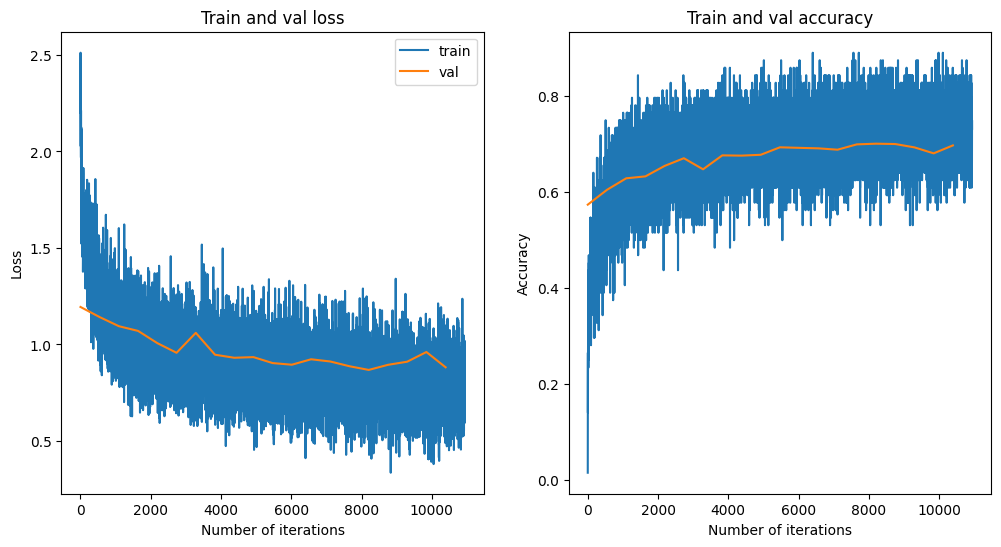

In [13]:
import seaborn as sns

def show_graphic(train_loss_log, train_acc_log, val_loss_log, val_acc_log, num_epoch):
  step = len(train_loss_log) // num_epoch
  fig, ax = plt.subplots(1, 2, figsize=(12, 6))
  train_loss, = ax[0].plot(train_loss_log, label = "train loss")
  val_loss, = ax[0].plot(list(range(0, len(train_loss_log), step)), val_loss_log, label="val loss")
  train_acc, = ax[1].plot(train_acc_log, label = "train acc")
  val_acc, = ax[1].plot(list(range(0, len(train_acc_log), step)), val_acc_log, label = "val acc" )
  ax[0].title.set_text('Train and val loss')
  ax[1].title.set_text('Train and val accuracy')

  ax[0].legend([train_loss, val_loss],['train', 'val'])
  ax[0].legend([train_acc, val_acc],['train', 'val'])

  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel("Number of iterations")

  ax[1].set_ylabel('Accuracy')
  ax[1].set_xlabel("Number of iterations")
  return fig, ax
show_graphic(train_loss_log, train_acc_log, val_loss_log, val_acc_log, 20)[0].show()



## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4926272494483475, train acc: 0.46595063985374774
 val loss: 1.283420868376468, val acc: 0.5517508865670955

Epoch 1
 train loss: 1.1692041544417358, train acc: 0.5928440846952268
 val loss: 1.1389933537929615, val acc: 0.6087765957446809

Epoch 2
 train loss: 1.064187806419742, train acc: 0.6333613541705952
 val loss: 1.0693196426046656, val acc: 0.6252216313747649

Epoch 3
 train loss: 1.0016100752070356, train acc: 0.6518183599006542
 val loss: 1.0279663385228908, val acc: 0.6485593973322118

Epoch 4
 train loss: 0.9706994406266012, train acc: 0.6625057130888568
 val loss: 1.0078759261902341, val acc: 0.6539007093044038

Epoch 5
 train loss: 0.938821583169034, train acc: 0.6744499217439613
 val loss: 0.9527945452548088, val acc: 0.6720079787234042

Epoch 6
 train loss: 0.9181050413051515, train acc: 0.6813340625117859
 val loss: 0.9841177980950538, val acc: 0.6625443263256804

Epoch 7
 train loss: 0.899936010785251, train acc: 0.6894138483722205
 val loss: 0.94

Посчитайте точность на тестовой выборке:

In [ ]:
test_loss_log, test_acc_log = test(net, test_loader)
test_acc_log

0.7144705414012739

**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.7929281565127468, train acc: 0.3736900953640668
 val loss: 1.5535180944077511, val acc: 0.4554521276595745

Epoch 1
 train loss: 1.4852651821847807, train acc: 0.47875587628572036
 val loss: 1.4087021792188603, val acc: 0.5024157801841168

Epoch 2
 train loss: 1.3805889627833252, train acc: 0.514376305901808
 val loss: 1.3354148793727794, val acc: 0.5265514184819892

Epoch 3
 train loss: 1.3161210591004142, train acc: 0.5373832920133741
 val loss: 1.2885315088515585, val acc: 0.5467863476022761

Epoch 4
 train loss: 1.2658418907325926, train acc: 0.5552730804387569
 val loss: 1.2571715281364766, val acc: 0.5589317377577436

Epoch 5
 train loss: 1.2243579682745924, train acc: 0.5709429681845949
 val loss: 1.195963057812224, val acc: 0.5798758865670955

Epoch 6
 train loss: 1.1924702675512548, train acc: 0.5828708541022795
 val loss: 1.1663282379190973, val acc: 0.5907801420130628

Epoch 7
 train loss: 1.153935405410404, train acc: 0.6005280426476948
 val loss: 1.1

In [ ]:
test_loss_log, test_acc_log = test(net, test_loader)
test_acc_log

0.660031847133758

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
lambda1 = lambda epoch: 0.65 ** epoch
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4697679338986955, train acc: 0.47843350091407677
 val loss: 1.2779947463502275, val acc: 0.5537455675449777

Epoch 1
 train loss: 1.1235753394785921, train acc: 0.6069102572784564
 val loss: 1.0966639310755628, val acc: 0.6158909574468086

Epoch 2
 train loss: 1.0101546026235089, train acc: 0.6524263842668132
 val loss: 0.988041419678546, val acc: 0.6623891845662543

Epoch 3
 train loss: 0.9378510924972172, train acc: 0.6757720684874429
 val loss: 0.9703011358037908, val acc: 0.6600620569066799

Epoch 4
 train loss: 0.8954823907376207, train acc: 0.6912215984063785
 val loss: 0.9216390749241443, val acc: 0.6808732271194458

Epoch 5
 train loss: 0.8683448445317514, train acc: 0.6991422369231689
 val loss: 0.9189688137237062, val acc: 0.6798980497299356

Epoch 6
 train loss: 0.8481570189134294, train acc: 0.705997812791542
 val loss: 0.8884739639911245, val acc: 0.6936170212765957

Epoch 7
 train loss: 0.8340945860040689, train acc: 0.711376175257144
 val loss: 0.8

In [ ]:
test_loss_log, test_acc_log = test(net, test_loader)
test_acc_log

0.6946656050955414

Попробуем запустить его же, но с другим шагом:

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
lambda1 = lambda epoch: 0.95 ** epoch
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4739988157474582, train acc: 0.47415284678966513
 val loss: 1.2159079399514705, val acc: 0.5694813829787234

Epoch 1
 train loss: 1.1529395785148662, train acc: 0.5957536237549302
 val loss: 1.118297659843526, val acc: 0.6136968085106383

Epoch 2
 train loss: 1.0366773445166007, train acc: 0.6384295835355518
 val loss: 1.0052298530619195, val acc: 0.652814716481148

Epoch 3
 train loss: 0.9798062686728385, train acc: 0.6582046553247372
 val loss: 1.0112213122083786, val acc: 0.6457446808510638

Epoch 4
 train loss: 0.9419688371025448, train acc: 0.6715852703211295
 val loss: 0.980754921030491, val acc: 0.6624556739279565

Epoch 5
 train loss: 0.9123634651330533, train acc: 0.6821665252802359
 val loss: 0.9759468086222385, val acc: 0.657535461161999

Epoch 6
 train loss: 0.8866715673118885, train acc: 0.6894220097409306
 val loss: 0.9068616785901658, val acc: 0.686192376055616

Epoch 7
 train loss: 0.8591857779723416, train acc: 0.7016151411223891
 val loss: 1.000

In [ ]:
test_loss_log, test_acc_log = test(net, test_loader)
test_acc_log

0.6950636942675159

LambdaLR работает по формуле $lr_{epoch} = lr_{initial} * Lambda(epoch)$

То есть, если мы делаем lambda1 = lambda epoch: 0.95 ** epoch, то каждый раз мы изменяем наш lr, умножая изначальный lr на 0.95 ** epoch


In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler =  optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4771064295411327, train acc: 0.4698599503942556
 val loss: 1.3908519841255025, val acc: 0.5127437944107868

Epoch 1
 train loss: 1.1117305844967718, train acc: 0.6114071886543818
 val loss: 1.0784059002044353, val acc: 0.6255762412192973

Epoch 2
 train loss: 1.048396662231773, train acc: 0.6352752024338494
 val loss: 1.0621082868981868, val acc: 0.6279255319148936

Epoch 3
 train loss: 1.041192842793857, train acc: 0.6384826325411335
 val loss: 1.0612529762247775, val acc: 0.6274601063829788

Epoch 4
 train loss: 1.0407628823459911, train acc: 0.6387805236976805
 val loss: 1.0608152838463478, val acc: 0.6272606382978724

Epoch 5
 train loss: 1.0407061814390108, train acc: 0.639009042893293
 val loss: 1.0611089356402132, val acc: 0.6275265957446808

Epoch 6
 train loss: 1.0396004980617293, train acc: 0.6400210564271623
 val loss: 1.061364950271363, val acc: 0.6263962765957447

Epoch 7
 train loss: 1.0389702465024246, train acc: 0.639376305901808
 val loss: 1.0612

In [ ]:
test_loss_log, test_acc_log = test(net, test_loader)
test_acc_log

0.6285828025477707

Попробуем этот же метод, но с другой гаммой

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler =  optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.5324879023884943, train acc: 0.4528842387513225
 val loss: 1.2911821210638006, val acc: 0.5468528369639782

Epoch 1
 train loss: 1.1857783987273682, train acc: 0.5843970358262768
 val loss: 1.1453212803982673, val acc: 0.5967641844394359

Epoch 2
 train loss: 1.0468130130218631, train acc: 0.6345896448470121
 val loss: 1.032117539517423, val acc: 0.6379432624958931

Epoch 3
 train loss: 0.9784512161336826, train acc: 0.6581189606263825
 val loss: 1.0106595006394894, val acc: 0.6483820922831272

Epoch 4
 train loss: 0.9433454781825189, train acc: 0.6732216310675445
 val loss: 0.9653983920178515, val acc: 0.6670434398854033

Epoch 5
 train loss: 0.9210424934270395, train acc: 0.6812075607519481
 val loss: 0.9510789249805693, val acc: 0.6707890071767442

Epoch 6
 train loss: 0.9131201630972421, train acc: 0.6850066923790048
 val loss: 0.9472190448578368, val acc: 0.6722739361702128

Epoch 7
 train loss: 0.9071995225859298, train acc: 0.6863370006001628
 val loss: 0.

In [ ]:
test_loss_log, test_acc_log = test(net, test_loader)
test_acc_log

0.6713773885350318

ExponentialLR работает по формуле $lr_{epoch} = Gamma * lr_{epoch-1}$.

То есть на каждой эпохе мы умножаем получившийся с предыдущий эпохи lr на какую-то константу

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=10, epochs=20,anneal_strategy='linear')
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)


Epoch 0
 train loss: 1.4937969938710578, train acc: 0.4673176743430673
 val loss: 1.2637677390524682, val acc: 0.5575797872340426

Epoch 1
 train loss: 1.2025634468800408, train acc: 0.5789248171846435
 val loss: 1.178714812309184, val acc: 0.5952792553191489

Epoch 2
 train loss: 1.0859845300261237, train acc: 0.6228453904880684
 val loss: 1.0966174247417044, val acc: 0.6056294327086591

Epoch 3
 train loss: 1.0175080620828452, train acc: 0.6456034539822468
 val loss: 1.0040705668165328, val acc: 0.6510638297872341

Epoch 4
 train loss: 0.9858234217441496, train acc: 0.6583882867745116
 val loss: 1.0259503336662943, val acc: 0.6431959220703612

Epoch 5
 train loss: 0.9712747699381883, train acc: 0.6608530296050217
 val loss: 1.0250050991139514, val acc: 0.6508421986661059

Epoch 6
 train loss: 0.946290885181706, train acc: 0.6723034736007397
 val loss: 0.9608989101775149, val acc: 0.6726728723404255

Epoch 7
 train loss: 0.9342797005198338, train acc: 0.6758047140712494
 val loss: 0.9

In [ ]:
test_loss_log, test_acc_log = test(net, test_loader)
test_acc_log

0.6648089171974523

Попробуем этот же метод, но с другими параметрами

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.9, steps_per_epoch=20, epochs=20,anneal_strategy='linear')
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)


Epoch 0
 train loss: 1.509448776515354, train acc: 0.46153532260078833
 val loss: 1.3256034638019318, val acc: 0.5316267731341909

Epoch 1
 train loss: 1.2229005562539945, train acc: 0.5688332463095349
 val loss: 1.114296654183814, val acc: 0.6111923759287976

Epoch 2
 train loss: 1.0998754815166132, train acc: 0.6198093497774937
 val loss: 1.07974435775838, val acc: 0.6182402483960415

Epoch 3
 train loss: 1.0447072058752642, train acc: 0.6381480152253913
 val loss: 1.0786420259069889, val acc: 0.6192819148936171

Epoch 4
 train loss: 0.9937658876562031, train acc: 0.654434088597132
 val loss: 1.0024275703633085, val acc: 0.6555851063829787

Epoch 5
 train loss: 0.979501316926597, train acc: 0.6594819144313471
 val loss: 1.029670157838375, val acc: 0.6413120569066798

Epoch 6
 train loss: 0.9638932117378471, train acc: 0.6664599112662363
 val loss: 1.0425899548733488, val acc: 0.6389406029214251

Epoch 7
 train loss: 0.9402097026652348, train acc: 0.6734134238860289
 val loss: 0.98628

In [ ]:
test_loss_log, test_acc_log = test(net, test_loader)
test_acc_log

0.6685907643312102

OneCycleLR работает по принципу: внутри одного цикла увеличивает исходный lr до максимального, а затем уменьшает его до минимального, который даже меньше изначального. Делает он это в данном случае линейно.

Похожее качество удалось получить только в LambdaLR с lambda1 = lambda epoch: 0.95 ** epoch

но при этом MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1) сработал немного лучше

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

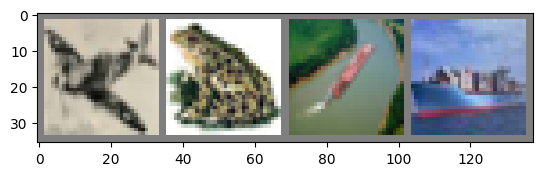

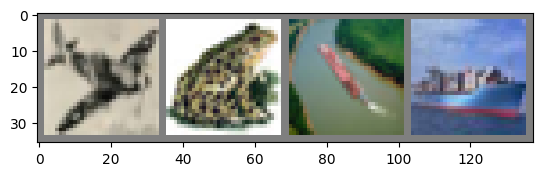

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [ ]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4851993246095925, train acc: 0.47048837818218975
 val loss: 1.3060203978355895, val acc: 0.5323138297872341

Epoch 1
 train loss: 1.1818506061703893, train acc: 0.5845398603235346
 val loss: 1.1228446645939605, val acc: 0.6064716313747649

Epoch 2
 train loss: 1.054794488702875, train acc: 0.6311332920133741
 val loss: 1.0868064692679873, val acc: 0.6274379433469569

Epoch 3
 train loss: 0.9995302464234109, train acc: 0.653858709923746
 val loss: 0.9983152201835145, val acc: 0.654033688027808

Epoch 4
 train loss: 0.9552802866294136, train acc: 0.6674351985319441
 val loss: 0.9828944081955767, val acc: 0.6575797872340425

Epoch 5
 train loss: 0.9229417854078945, train acc: 0.6792814704356289
 val loss: 0.965389033834985, val acc: 0.6597960993330529

Epoch 6
 train loss: 0.9055642340693221, train acc: 0.6887690977378998
 val loss: 0.9497250567091272, val acc: 0.6739140071767442

Epoch 7
 t

Посчитайте точность на тестовой выборке:

In [ ]:
test_loss_log, test_acc_log = test(net, test_loader)
test_acc_log

0.7273089171974523

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

In [ ]:
transform = transforms.Compose(
        [transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.552502060503149, train acc: 0.447285518458818
 val loss: 1.3762185548214203, val acc: 0.504654255319149

Epoch 1
 train loss: 1.284180759184975, train acc: 0.5465934317988059
 val loss: 1.1828414990546856, val acc: 0.5822916667512122

Epoch 2
 train loss: 1.1766311019604558, train acc: 0.588216570984075
 val loss: 1.1629450917243958, val acc: 0.5942375888215735

Epoch 3
 train loss: 1.1175582554920065, train acc: 0.6113337360090921
 val loss: 1.086758235921251, val acc: 0.6275487590343394

Epoch 4
 train loss: 1.0711158200199469, train acc: 0.626840395726931
 val loss: 1.0765428999637037, val acc: 0.62788120584285

Epoch 5
 train loss: 1.0394098965733753, train acc: 0.6328594281424987
 val loss: 1.0936784531207795, val acc: 0.6199911348363186

Epoch 6
 train loss: 1.0170649573397592, train acc: 0.6445179878030878
 val loss: 1.008739144751366, val acc: 0.6521498228641267

Epoch 7
 train lo

In [ ]:
test_loss_log, test_acc_log = test(net, test_loader)
test_acc_log

0.68640525477707

Сигма в Gaussian blur - это стандартное отклонение, которое выбирается между 0.1 и 0.2

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.ColorJitter(brightness=(0.5,1.5), contrast=(0.1, 1),saturation=(0.5,1.5),hue=(-0.1,0.1)),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
                              )


train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)


Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.820526192785399, train acc: 0.34652487604012217
 val loss: 1.6246868767636888, val acc: 0.42524379441078675

Epoch 1
 train loss: 1.5168961776893797, train acc: 0.46621180474213314
 val loss: 1.3752858765581821, val acc: 0.5212544327086591

Epoch 2
 train loss: 1.3627717489516278, train acc: 0.5250840624573025
 val loss: 1.3120498360471522, val acc: 0.5514184398854033

Epoch 3
 train loss: 1.2942165635403593, train acc: 0.55486909116208
 val loss: 1.3127954888851086, val acc: 0.5568040780564572

Epoch 4
 train loss: 1.2454811484983679, train acc: 0.5723712131571727
 val loss: 1.2859221133779972, val acc: 0.5546985816448293

Epoch 5
 train loss: 1.214397409062499, train acc: 0.586323126142596
 val loss: 1.211838266443699, val acc: 0.5891400710065314

Epoch 6
 train loss: 1.1769537252307591, train acc: 0.5971818687275079
 val loss: 1.1844944340117434, val acc: 0.5946365248649679

Epoch 7
 t

In [ ]:
test_loss_log, test_acc_log = test(net, test_loader)
test_acc_log

0.6652070063694268

ColorJitter рандомно меняет яркость, контраст, сатурацию и цвета в границах от минимального, до максимального, которые указаны для каждого параметра.

In [ ]:
transform = transforms.Compose(
        [transforms.ElasticTransform(alpha=100.0),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.6656491453512494, train acc: 0.39677461485976057
 val loss: 1.5356370692557477, val acc: 0.44261968085106385

Epoch 1
 train loss: 1.4556774200643439, train acc: 0.48003721602220206
 val loss: 1.4013715769382233, val acc: 0.5034574468085107

Epoch 2
 train loss: 1.3764703140834131, train acc: 0.5055742361863744
 val loss: 1.3376899120655465, val acc: 0.5283023050490846

Epoch 3
 train loss: 1.330408013934845, train acc: 0.5270672826270081
 val loss: 1.301761541468032, val acc: 0.5369680851063829

Epoch 4
 train loss: 1.2871930321348215, train acc: 0.5433655981607803
 val loss: 1.275028905969985, val acc: 0.5508421986661058

Epoch 5
 train loss: 1.2526104854491336, train acc: 0.5557546030450783
 val loss: 1.2619064546645955, val acc: 0.5533909574468086

Epoch 6
 train loss: 1.2348352675028214, train acc: 0.5597210433844892
 val loss: 1.196768088290032, val acc: 0.5755097518575952

Epoch 7


In [ ]:
test_loss_log, test_acc_log = test(net, test_loader)
test_acc_log

0.6436106687898089

ElasticTransform рандомно размывает объекты с эффектом, что мы видим их через воду. $\alpha$ отвечает за магнитуду размытия.

In [ ]:
transform = transforms.Compose(
        [transforms.RandomGrayscale(p=0.1),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.5075631587335352, train acc: 0.4636736093752999
 val loss: 1.275867266350604, val acc: 0.5429521276595745

Epoch 1
 train loss: 1.1922324966686952, train acc: 0.5856090036563071
 val loss: 1.1518122348379582, val acc: 0.5993794327086591

Epoch 2
 train loss: 1.0654350856976273, train acc: 0.6298111452698926
 val loss: 1.096750070693645, val acc: 0.6237367021276595

Epoch 3
 train loss: 1.0071016070611734, train acc: 0.6527120332613288
 val loss: 0.9849044629868041, val acc: 0.6594858156873825

Epoch 4
 train loss: 0.9609206613064684, train acc: 0.6662028271711723
 val loss: 1.0251869965106883, val acc: 0.6433510638297872

Epoch 5
 train loss: 0.9274036048535237, train acc: 0.6781347937732117
 val loss: 0.9958825884981358, val acc: 0.6501329787234043

Epoch 6
 train loss: 0.9041592782223682, train acc: 0.6885446592266424
 val loss: 0.9462283872543498, val acc: 0.6728501773895101

Epoch 7
 

In [ ]:
test_loss_log, test_acc_log = test(net, test_loader)
test_acc_log

0.7205414012738853

RandomGrayscale переводит изображение из 3-х канального в 1-канальное с вероятностью p.

In [ ]:
transform = transforms.Compose(
        [transforms.ElasticTransform(alpha=100.0),
         transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
         transforms.RandomGrayscale(p=0.1),
         transforms.ToTensor(),
         transforms.ColorJitter(brightness=(0.5,1.5), contrast=(1),saturation=(0.5,1.5),hue=(-0.1,0.1)),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.9733793768194083, train acc: 0.2850287281507984
 val loss: 1.8576750664000816, val acc: 0.32601950358837206

Epoch 1
 train loss: 1.8122526300454707, train acc: 0.34835302955053843
 val loss: 1.76395619219922, val acc: 0.3636303191489362

Epoch 2
 train loss: 1.744593297977552, train acc: 0.37444910554171046
 val loss: 1.748511329610297, val acc: 0.37440159574468085

Epoch 3
 train loss: 1.7077964814533044, train acc: 0.38913554454416416
 val loss: 1.7352096598199074, val acc: 0.375908688027808

Epoch 4
 train loss: 1.6740151312495062, train acc: 0.4012103356434615
 val loss: 1.6799449935872504, val acc: 0.39982269507773377

Epoch 5
 train loss: 1.6433154797859122, train acc: 0.4123547271139225
 val loss: 1.6426135053025914, val acc: 0.412344858240574

Epoch 6
 train loss: 1.6290234340392258, train acc: 0.4183982436901037
 val loss: 1.6009020769849736, val acc: 0.4348182624958931

Epoch 7

In [ ]:
test_loss_log, test_acc_log = test(net, test_loader)
test_acc_log

0.5629976114649682

Все вместе сработало совем плохо

В целом логично, что наши методы в основном не дали очень хороший результат, потому что исхожные картинки очень маленькие, всего 32x32 и в плохом качестве. Только RandomGrayscale дал результат лучше, чем RandomHorizontalFlip.

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [14]:
import wandb

In [15]:
net = BasicBlockNet()
net = net.to(device)

In [16]:
%wandb

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [18]:

def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)

        output = model(data)

        loss = loss_fn(output, target)
        loss_log.append(loss.item())
        acc = (output.argmax(dim=1) == target).sum() / data.shape[0]
        acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(data)

        loss = loss_fn(output, target)
        loss.backward()
        loss_log.append(loss.item())
        acc = (output.argmax(dim=1) == target).sum() / data.shape[0]
        acc_log.append(acc.item())
        optimizer.step()

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []
    train_loss_graph = []
    train_acc_graph = []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)


        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        f, ax = show_graphic(train_loss_log,train_acc_log, val_loss_log, val_acc_log, epoch + 1)
        wandb.log({"Accuracy":ax[0]})
        wandb.log({"Loss": ax[1]})
        if scheduler is not None:
            scheduler.step()
    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [19]:
run = wandb.init(project="dl_shw2")
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)
run.finish()

wandb: Currently logged in as: polina-kadeyshvili (gans_project). Use `wandb login --relogin` to force relogin


Epoch 0
 train loss: 1.4696083707391017, train acc: 0.4775969574612717
 val loss: 1.3312153040094579, val acc: 0.5315824468085106



/opt/conda/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Epoch 1
 train loss: 1.1625131026482451, train acc: 0.5935459650194841
 val loss: 1.156990075365026, val acc: 0.5996232269926274

Epoch 2
 train loss: 1.054265126122853, train acc: 0.632202435455113
 val loss: 1.2194838493428333, val acc: 0.5798537234042553

Epoch 3
 train loss: 0.9899213725949554, train acc: 0.6522876404539105
 val loss: 0.9801145591634385, val acc: 0.6627216312479466

Epoch 4
 train loss: 0.9450792501351951, train acc: 0.6729849503942555
 val loss: 0.9768973180588255, val acc: 0.6584441489361702

Epoch 5
 train loss: 0.9163152995013668, train acc: 0.6853943589182615
 val loss: 0.9541278750338453, val acc: 0.6748226950777337

Epoch 6
 train loss: 0.8993402602903586, train acc: 0.6863574040219378
 val loss: 0.9236750808167965, val acc: 0.6813608156873825

Epoch 7
 train loss: 0.8797683734344608, train acc: 0.693641453382084
 val loss: 0.9100130570695756, val acc: 0.690314716481148

Epoch 8
 train loss: 0.8624200787143254, train acc: 0.6992769000517167
 val loss: 0.8981

https://wandb.ai/gans_project/dl_shw2/runs/r2knp4f4?workspace=user-polina-kadeyshvili